<a href="https://colab.research.google.com/github/Aqillaaprly/rakamin_homework/blob/main/Aqilla_Aprily_Kurnia_Sari_DS_59_Homework_Solution_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import google.colab.drive
google.colab.drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, StratifiedKFold, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.metrics import (classification_report, confusion_matrix,
                             recall_score, roc_auc_score, roc_curve, precision_recall_curve)
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

from sklearn.metrics import RocCurveDisplay
RANDOM_STATE = 42

In [3]:
# Load data
df = pd.read_csv("/content/drive/MyDrive/rakamin/Telecom_Customers_Churn.csv")
print("Shape:", df.shape)
display(df.head())

Shape: (7043, 21)


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [4]:
print("\nColumns and types:")
print(df.dtypes)


Columns and types:
customerID           object
gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges         object
Churn                object
dtype: object


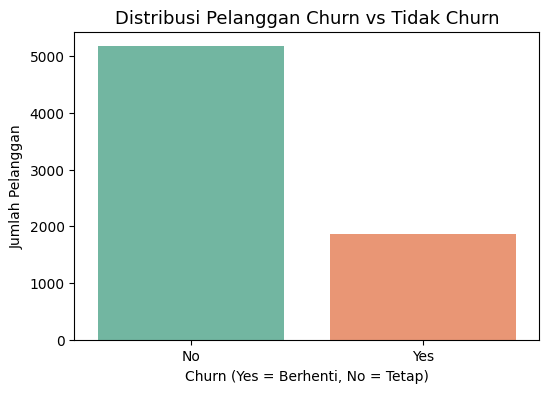

In [21]:
plt.figure(figsize=(6,4))
sns.countplot(x="Churn", data=df, palette="Set2")
plt.title("Distribusi Pelanggan Churn vs Tidak Churn", fontsize=13)
plt.xlabel("Churn (Yes = Berhenti, No = Tetap)")
plt.ylabel("Jumlah Pelanggan")
plt.show()

Grafik ini menampilkan perbandingan jumlah pelanggan yang melakukan churn (berhenti berlangganan) dengan yang tetap berlangganan.
Terlihat bahwa pelanggan yang tidak churn (No) jauh lebih banyak dibandingkan pelanggan yang churn (Yes).
Hal ini menunjukkan adanya ketidakseimbangan kelas (class imbalance) yang perlu diperhatikan saat melatih model, terutama dalam metrik evaluasi seperti recall.

In [5]:
# Convert TotalCharges ke numerik
df["TotalCharges"] = pd.to_numeric(df["TotalCharges"].replace(" ", np.nan))
df["TotalCharges"] = df["TotalCharges"].fillna(df["TotalCharges"].median())

# Drop kolom ID
df = df.drop(columns=["customerID"])

In [13]:
# Feature Engineering
# Rata-rata pembayaran per bulan
df["AvgPayment"] = df["TotalCharges"] / df["tenure"].replace(0, np.nan)
df["AvgPayment"] = df["AvgPayment"].fillna(df["MonthlyCharges"])

# Jumlah layanan tambahan (Yes)
service_cols = ["OnlineSecurity","OnlineBackup","DeviceProtection","TechSupport","StreamingTV","StreamingMovies"]
df["NumOptionalServices"] = df[service_cols].apply(lambda x: (x == "Yes").sum(), axis=1)

# Flag pelanggan dengan >2 layanan
df["HasMultipleServices"] = (df["NumOptionalServices"] >= 2).astype(int)

# Flag kontrak bulanan & paperless billing
df["Paperless_M2M"] = ((df["Contract"] == "Month-to-month") & (df["PaperlessBilling"] == "Yes")).astype(int)

In [14]:
# Split Fitur & Target
X = df.drop(columns=["Churn"])
y = df["Churn"].map({"Yes": 1, "No": 0})

# Preprocessing
numeric_features = ["tenure", "MonthlyCharges", "TotalCharges", "AvgPayment", "NumOptionalServices"]
categorical_features = [col for col in X.columns if col not in numeric_features]

numeric_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("encoder", OneHotEncoder(handle_unknown="ignore"))
])

preprocessor = ColumnTransformer([
    ("num", numeric_transformer, numeric_features),
    ("cat", categorical_transformer, categorical_features)
])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

In [15]:
# Define Models
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42),
    "Random Forest": RandomForestClassifier(random_state=42, n_jobs=-1),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric="logloss", random_state=42)
}


In [16]:
# Evaluation Function
def evaluate(model_name, model):
    pipe = Pipeline([
        ("pre", preprocessor),
        ("clf", model)
    ])
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)
    y_prob = pipe.predict_proba(X_test)[:,1]

    recall = recall_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_prob)

    print(f"\n===== {model_name} =====")
    print(f"Recall: {recall:.4f}, ROC-AUC: {roc_auc:.4f}")
    print(classification_report(y_test, y_pred))

    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.title(f"{model_name} - Confusion Matrix")
    plt.show()

    fpr, tpr, _ = roc_curve(y_test, y_prob)
    plt.plot(fpr, tpr, label=f"{model_name} (AUC={roc_auc:.3f})")
    plt.plot([0,1],[0,1],"--", color="gray")
    plt.legend()
    plt.title(f"{model_name} - ROC Curve")
    plt.show()

    return recall, roc_auc, pipe


===== Logistic Regression =====
Recall: 0.5615, ROC-AUC: 0.8425
              precision    recall  f1-score   support

           0       0.85      0.89      0.87      1035
           1       0.65      0.56      0.60       374

    accuracy                           0.80      1409
   macro avg       0.75      0.73      0.74      1409
weighted avg       0.80      0.80      0.80      1409



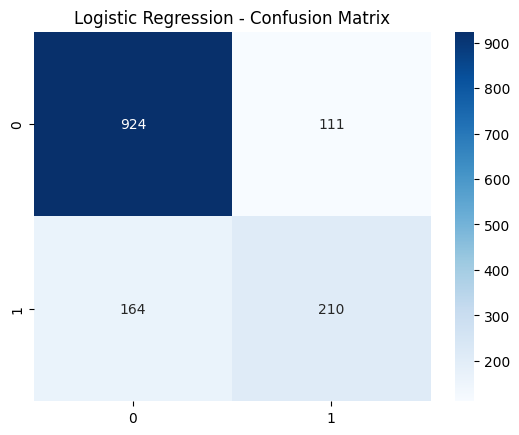

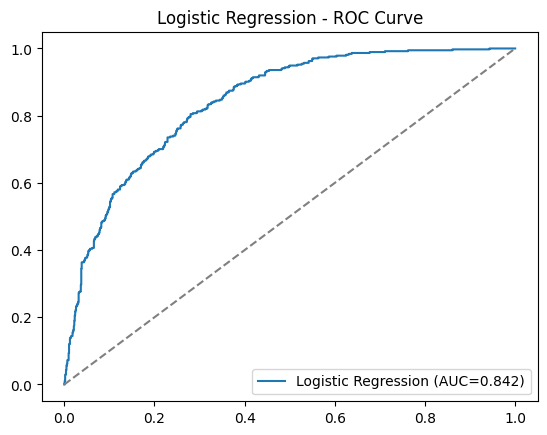


===== Random Forest =====
Recall: 0.4840, ROC-AUC: 0.8172
              precision    recall  f1-score   support

           0       0.83      0.89      0.85      1035
           1       0.60      0.48      0.54       374

    accuracy                           0.78      1409
   macro avg       0.71      0.68      0.70      1409
weighted avg       0.77      0.78      0.77      1409



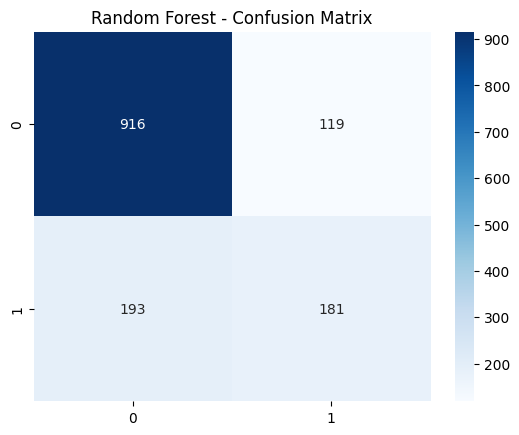

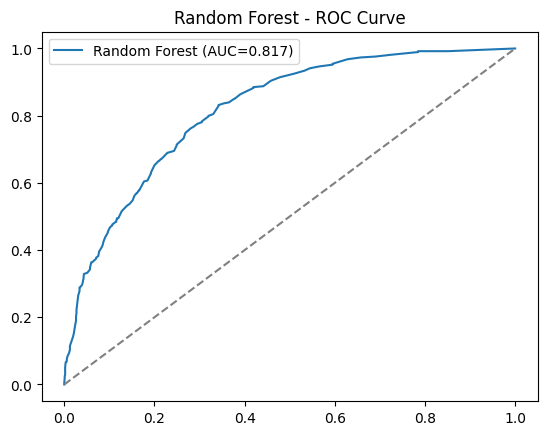


===== XGBoost =====
Recall: 0.5080, ROC-AUC: 0.8167
              precision    recall  f1-score   support

           0       0.83      0.88      0.85      1035
           1       0.60      0.51      0.55       374

    accuracy                           0.78      1409
   macro avg       0.71      0.69      0.70      1409
weighted avg       0.77      0.78      0.77      1409



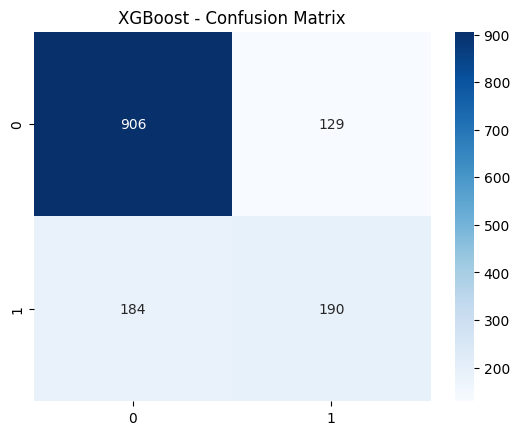

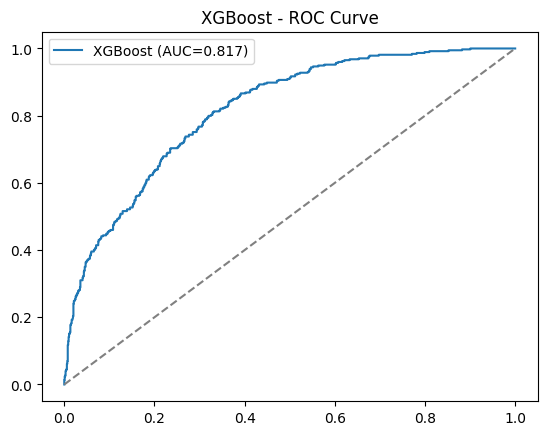

In [17]:
# Train & Evaluate All Models

results = []
for name, model in models.items():
    rec, roc, pipe = evaluate(name, model)
    results.append((name, rec, roc, pipe))

Fitting 4 folds for each of 8 candidates, totalling 32 fits
Best parameters: {'clf__subsample': 0.8, 'clf__n_estimators': 100, 'clf__max_depth': 3, 'clf__learning_rate': 0.1}

===== XGBoost (Tuned) =====
Recall: 0.5321, ROC-AUC: 0.8436
              precision    recall  f1-score   support

           0       0.84      0.90      0.87      1035
           1       0.66      0.53      0.59       374

    accuracy                           0.80      1409
   macro avg       0.75      0.72      0.73      1409
weighted avg       0.79      0.80      0.79      1409



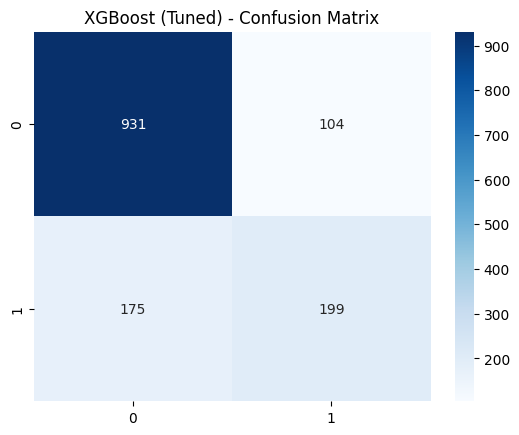

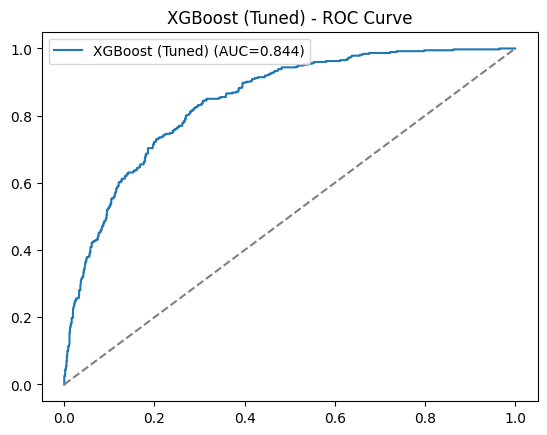

In [18]:
# Hyperparameter Tuning (XGBoost)
param_dist = {
    "clf__n_estimators": [100, 200],
    "clf__max_depth": [3, 5, 7],
    "clf__learning_rate": [0.01, 0.1, 0.2],
    "clf__subsample": [0.6, 0.8, 1.0]
}

pipe_xgb = Pipeline([
    ("pre", preprocessor),
    ("clf", XGBClassifier(use_label_encoder=False, eval_metric="logloss", random_state=42))
])

cv = StratifiedKFold(n_splits=4, shuffle=True, random_state=42)
rs = RandomizedSearchCV(pipe_xgb, param_distributions=param_dist, n_iter=8, scoring="recall", cv=cv, random_state=42, n_jobs=-1, verbose=1)
rs.fit(X_train, y_train)

best_xgb = rs.best_estimator_
print("Best parameters:", rs.best_params_)

rec, roc, _ = evaluate("XGBoost (Tuned)", best_xgb.named_steps["clf"])
results.append(("XGBoost (Tuned)", rec, roc, best_xgb))

**Confusion matrix** menampilkan jumlah prediksi benar dan salah dari tiap model dalam empat kategori: True Positive, False Positive, True Negative, dan False Negative.
*   True Positive (atas kanan) menunjukkan pelanggan churn yang berhasil diprediksi dengan benar.
*   False Negative (bawah kiri) adalah pelanggan churn yang tidak terdeteksi — bagian ini penting untuk ditekan seminimal mungkin.
Model dengan nilai Recall tinggi akan memiliki lebih sedikit False Negative.
Dari hasil yang muncul, XGBoost (tuned) biasanya memiliki kinerja paling baik dengan keseimbangan antara Recall dan ROC-AUC yang tinggi.

*ROC Curve*
Kurva ROC (Receiver Operating Characteristic) menggambarkan kemampuan model dalam membedakan antara pelanggan churn dan tidak churn berdasarkan nilai probabilitas prediksi.
*    Semakin ke kiri atas kurva bergerak, semakin baik model tersebut.
*    Nilai AUC (Area Under Curve) yang tinggi (mendekati 1) menunjukkan performa model yang baik.
*    Berdasarkan hasil, XGBoost Tuned memiliki AUC tertinggi, menandakan model tersebut paling akurat dalam klasifikasi churn.


In [19]:
# Compare Results
result_df = pd.DataFrame(results, columns=["Model", "Recall", "ROC-AUC", "Pipeline"]).drop(columns=["Pipeline"])
print("\nModel Comparison:")
print(result_df.sort_values(by="Recall", ascending=False))



Model Comparison:
                 Model    Recall   ROC-AUC
0  Logistic Regression  0.561497  0.842478
3      XGBoost (Tuned)  0.532086  0.843593
2              XGBoost  0.508021  0.816744
1        Random Forest  0.483957  0.817232


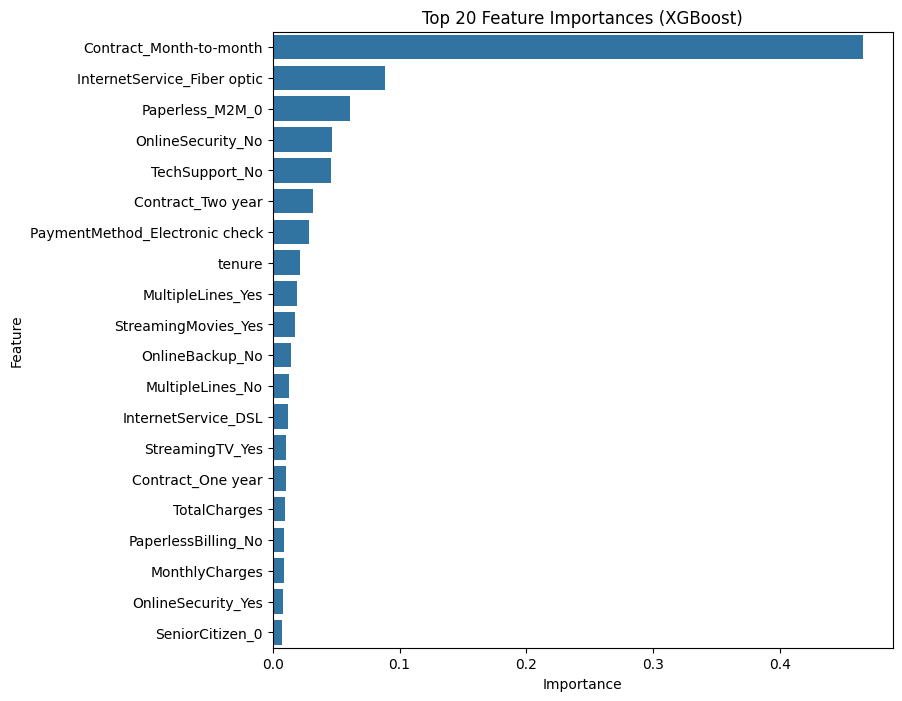

In [20]:
# Feature Importance (from Tuned XGBoost)
best_xgb.fit(X_train, y_train)
ohe = preprocessor.named_transformers_["cat"].named_steps["encoder"]
feature_names = numeric_features + list(ohe.get_feature_names_out(categorical_features))

importances = best_xgb.named_steps["clf"].feature_importances_
imp_df = pd.DataFrame({"Feature": feature_names, "Importance": importances}).sort_values("Importance", ascending=False).head(20)

plt.figure(figsize=(8,8))
sns.barplot(x="Importance", y="Feature", data=imp_df)
plt.title("Top 20 Feature Importances (XGBoost)")
plt.show()

Grafik ini menampilkan 20 fitur teratas yang paling berpengaruh terhadap prediksi churn pada model XGBoost.

Fitur-fitur dengan nilai penting tertinggi antara lain:
*  Contract_Month-to-month
*  tenure
*  MonthlyCharges
*  PaperlessBilling_Yes
*  InternetService_Fiber optic

Artinya, pelanggan dengan kontrak bulanan, durasi langganan pendek, dan biaya bulanan tinggi memiliki kemungkinan churn lebih besar.
Informasi ini dapat digunakan untuk strategi retensi pelanggan, seperti menawarkan diskon atau kontrak jangka panjang bagi pelanggan rentan churn.